In [1]:
import os
import sys
import time
import pickle

%load_ext autoreload
%autoreload 1
%aimport DkNN,AISE

from collections import Counter

import matplotlib.pyplot   as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors,KNeighborsClassifier

import torch
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
from torch.utils.data.dataset import random_split
from torchvision              import datasets 
from torchvision              import transforms

from DkNN import CKNN
import utilities
from mnist_model import CNN
from attack import PGD
from AISE import *

device = torch.device('cuda')
config = utilities.config_to_namedtuple(utilities.get_config('config_mnist.json'))

mnist_trainset = datasets.MNIST(root='./datasets', train=True, download=False, transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.,), (1,))
]))
mnist_testset = datasets.MNIST(root='./datasets', train=False, download=False, transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.,), (1,))
]))

train_loader = torch.utils.data.DataLoader(mnist_trainset,
    shuffle = True,
    batch_size = 64
)


test_loader = torch.utils.data.DataLoader(mnist_testset,
    shuffle = False,
    batch_size = 64
)

filename = 'models/mnistmodel.pt'
model = CNN().to(device)

if os.path.isfile(filename):
    print("=> loading checkpoint '{}'".format(filename))
    checkpoint = torch.load(filename,map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    print("=> loaded checkpoint '{}' (epoch {})"
              .format(filename, checkpoint['epoch']))
else:
    print("=> no checkpoint found at '{}'".format(filename))

=> loading checkpoint 'models/mnistmodel.pt'
=> loaded checkpoint 'models/mnistmodel.pt' (epoch 55)


In [25]:
for layer in model.modules():
    print(layer)

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=6272, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Linear(in_features=6272, out_features=256, bias=True)
Linear(in_features=256, out_features=256, bias=True)
Linear(in_features=256, out_features=10, bias=True)


In [19]:
for k,v in model.state_dict().items():
    print(k,'\t',v.size())

conv1.weight 	 torch.Size([64, 1, 3, 3])
conv1.bias 	 torch.Size([64])
conv2.weight 	 torch.Size([64, 64, 3, 3])
conv2.bias 	 torch.Size([64])
conv3.weight 	 torch.Size([128, 64, 3, 3])
conv3.bias 	 torch.Size([128])
conv4.weight 	 torch.Size([128, 128, 3, 3])
conv4.bias 	 torch.Size([128])
fc1.weight 	 torch.Size([256, 6272])
fc1.bias 	 torch.Size([256])
fc2.weight 	 torch.Size([256, 256])
fc2.bias 	 torch.Size([256])
fc3.weight 	 torch.Size([10, 256])
fc3.bias 	 torch.Size([10])


In [2]:
def feature_space(net, n_layers, inputs, labels, device, batch_size=128):

    conv_features = [[] for _ in range(n_layers)]
    targets       = []
    predictions   = []
    print('\tRunning predictions')
    net.eval()
    for ind in range(0,inputs.size(0),batch_size):
        X,y = inputs[ind:ind+batch_size],labels[ind:ind+batch_size]
        *out_convs, out = net(X.to(device))
        y_pred = torch.max(out,1)[1]
        for i, out_conv in enumerate(out_convs):
            conv_feat = out_conv.view(out_conv.size(0), -1).detach().cpu()
            conv_features[i].append(conv_feat)
        targets.append(y.numpy())
        predictions.append(y_pred.detach().cpu().numpy())
    print('\tConcatenating results')
    conv_features = [torch.cat(out_convs) for out_convs in conv_features]
    targets       = np.concatenate(targets)
    predictions   = np.concatenate(predictions)

    return conv_features, targets, predictions

model.eval()

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=6272, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [3]:
np.random.seed(1234)
ind_full = np.arange(60000)
np.random.shuffle(ind_full)
ind_partial = ind_full[:2000]
X_train_partial = mnist_trainset.data[ind_partial].unsqueeze(1)/255.
y_train_partial = mnist_trainset.targets[ind_partial]

In [8]:
y_pred_cnn = torch.max(model(X_train_partial.to(device))[-1],dim=-1)[1]
print('Accuracy of CNN is {}'.format((y_pred_cnn.cpu()==y_train_partial).float().mean()))

Accuracy of CNN is 0.9990000128746033


In [10]:
ind_eval = ind_full[2000:2200]
X_eval = mnist_trainset.data[ind_eval].unsqueeze(1)/255.
y_eval = mnist_trainset.targets[ind_eval]

In [11]:
X_adv = PGD(eps=40/255.,sigma=20/255.,nb_iter=20,DEVICE=device).attack_batch(model,X_eval.to(device),y_eval.to(device),batch_size=64)
*_,out = model(X_adv)
y_pred_adv = torch.max(out,1)[1]
print('The accuracy of plain cnn under PGD attacks is: {:f}'.format((y_eval.numpy()==y_pred_adv.detach().cpu().numpy()).mean())) 

The accuracy of plain cnn under PGD attacks is: 0.180000


In [12]:
X_hidden_partial, _, _ = feature_space(model, 4, X_train_partial, y_train_partial, device, 128)
X_hidden_eval, _, _ = feature_space(model, 4, X_eval, y_eval, device, 128)
X_hidden_adv, _, _ = feature_space(model, 4, X_adv, y_eval, device, 128)

	Running predictions
	Concatenating results
	Running predictions
	Concatenating results
	Running predictions
	Concatenating results


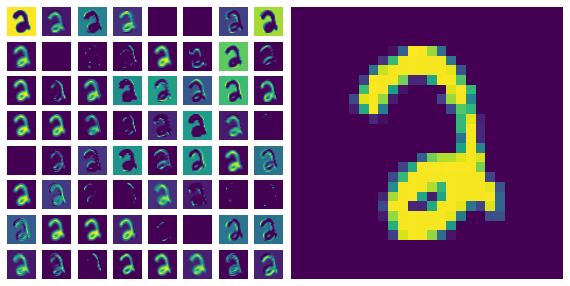

In [14]:
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(8,16)
for i in range(64):
    ax = fig.add_subplot(gs[i//8,i%8])
    ax.imshow(X_hidden_partial[0].view(-1,64,28,28)[0][i])
    ax.axis('off')
ax = fig.add_subplot(gs[:,8:])
ax.imshow(X_train_partial[0].squeeze(0))
ax.axis('off')
fig.savefig('images/cnn_conv1_clean.jpg')

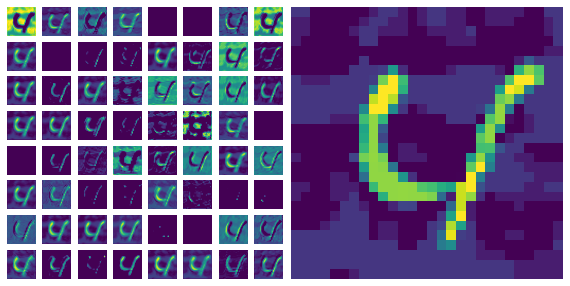

In [15]:
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(8,16)
for i in range(64):
    ax = fig.add_subplot(gs[i//8,i%8])
    ax.imshow(X_hidden_adv[0].view(-1,64,28,28)[0][i])
    ax.axis('off')
ax = fig.add_subplot(gs[:,8:])
ax.imshow(X_adv[0].cpu().numpy().reshape(28,28))
ax.axis('off')
fig.savefig('images/cnn_conv1_adv.jpg')

In [65]:
knn_conv1 = KNeighborsClassifier(n_neighbors=5)
knn_conv1.fit(X_hidden_partial[0].numpy(),y_train_partial.numpy())
pred_conv1 = knn_conv1.predict(X_hidden_eval[0].numpy())
acc_conv1 = (pred_conv1==y_eval.numpy()).astype('float').mean()
print('The accuracy by knn with hidden layer 1 is {}'.format(acc_conv1))
pred_conv1_adv = knn_conv1.predict(X_hidden_adv[0].numpy())
acc_conv1_adv = (pred_conv1_adv==y_eval.numpy()).astype('float').mean()
print('The accuracy by knn with hidden layer 1 of adversarial examples is {}'.format(acc_conv1_adv))

The accuracy by knn with hidden layer 1 is 0.92
The accuracy by knn with hidden layer 1 of adversarial examples is 0.84


### Comparison between AISE and plain KNN

### random mutation

In [26]:
aise = AISE(X_train_partial,y_train_partial,n_neighbors=100,n_class=0,model=model)

Building one single query object 2000 samples...done!


In [27]:
aise.__dict__.update

{'model': CNN(
   (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (fc1): Linear(in_features=6272, out_features=256, bias=True)
   (fc2): Linear(in_features=256, out_features=256, bias=True)
   (fc3): Linear(in_features=256, out_features=10, bias=True)
 ),
 'device': device(type='cuda'),
 'input_shape': (1, 28, 28),
 'X_orig': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'y_orig': tensor([2, 7, 1,  ..., 9, 3, 0]),
 'layer_dims': [],
 'transform': <function AISE.AISE.__init__.<locals>.<lambda>(x, *y)>,
 'n_class':

In [8]:
aise = AISE(X_train_partial,y_train_partial,n_neighbors=100,n_class=0,model=model,mut_mode="random",fitness_function=neg_l2_dist)
start_time = time.time()
mem_bcs,mem_labs,pla_bcs,pla_labs,fit_log = aise.clonal_expansion(X_adv.cpu(),return_log=True)
end_time = time.time()
print("Total running time is {}s.".format(end_time-start_time))
aise_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],pla_labs.numpy())))
print('The accuracy of majority voting by AISE against adversarial samples is: {}'.format((aise_pred==y_eval.numpy()).mean()))

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_partial.flatten(start_dim=1).numpy(),y_train_partial.numpy())
knn_pred = knn.predict(X_adv.cpu().numpy().reshape(X_adv.size(0),-1))
print('The accuaracy of plain KNN against adversarial samples is: {}'.format((knn_pred==y_eval.numpy()).mean()))

Building one single query object 2000 samples...done!
Clonal expansion starts...
Searching 100 naive B cells for each of 200 antigens...done!
Affinity maturation process starts with population of 1000...
Memory & plasma B cells generated!
10000 plasma B cells and 40000 memory generated!
Total running time is 110.65194630622864s.
The accuracy of majority voting by AISE against adversarial samples is: 0.83
The accuaracy of plain KNN against adversarial samples is: 0.835


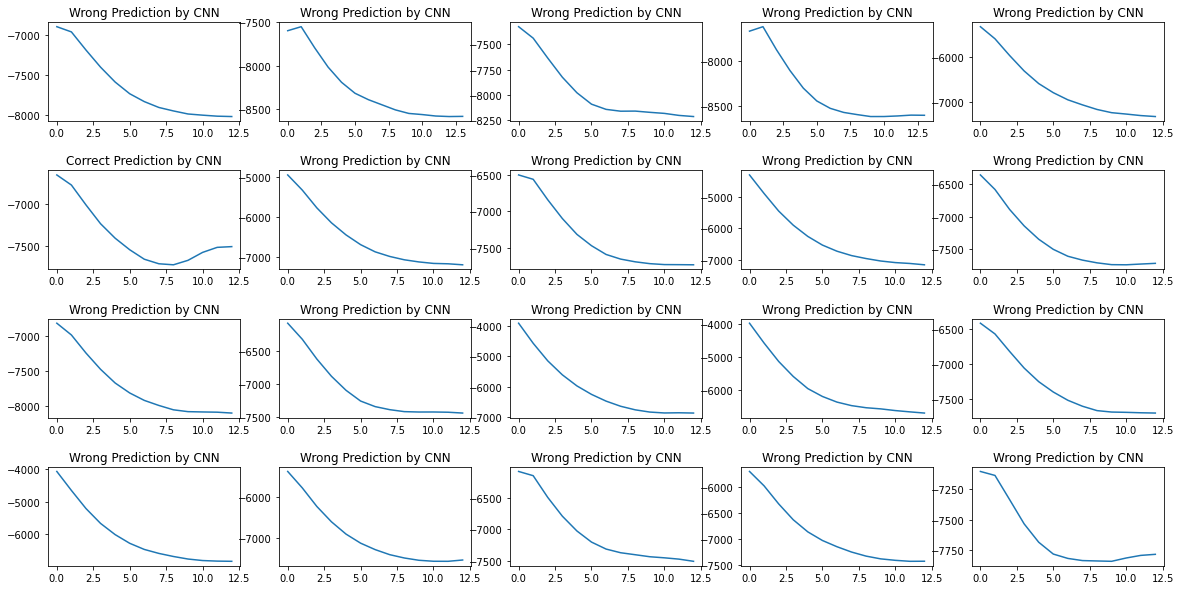

In [47]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=.5)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.plot(fit_log[i])
    plt.title(f'{"Wrong" if y_pred_adv[i].item()!=y_eval[i].item() else "Correct"} Prediction by CNN')

Text(0.5, 1.0, 'Histogram of KNN confidence')

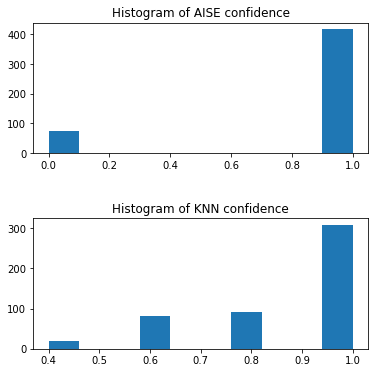

In [48]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=.5)
plt.subplot(2,1,1)
plt.hist((pla_labs==y_eval.reshape(-1,1)).float().mean(dim=1))
plt.title('Histogram of AISE confidence')
plt.subplot(2,1,2)
plt.hist(knn.predict_proba(X_adv.detach().cpu().flatten(start_dim=1).numpy()).max(axis=1))
plt.title('Histogram of KNN confidence')

In [10]:
np.nonzero(np.logical_and(aise_pred != y_eval.numpy(),knn_pred == y_eval.numpy())),\
np.nonzero(np.logical_and(aise_pred == y_eval.numpy(),knn_pred != y_eval.numpy()))

((array([  0,   6,  45,  57,  65,  89,  93, 148, 151, 172, 184], dtype=int64),),
 (array([  1,  12,  15,  21,  59,  79,  81,  87, 108, 121, 179, 182, 185],
        dtype=int64),))

In [12]:
def set_subplots(data,ncol=5,num_max=20,y_names=('aise','knn')):
    '''
    data are composed of original images, prediction 1, prediction 2
    '''
    X,y_1,y_2 = data
    def display_subplots(ind):
        fig,ax = plt.subplots(len(ind)//ncol+1,ncol,
                              figsize=(3*ncol,3*len(ind)//ncol+3))
        fig.subplots_adjust(wspace=.8)
        for n,i in enumerate(ind):
            ax[n//ncol][n%ncol].imshow(X[i])
            ax[n//ncol][n%ncol].set_title('{}:{} vs {}:{}'.format(y_names[0],y_1[i],y_names[1],y_2[i]))
            ax[n//ncol][n%ncol].axis('off')
        for m in range(n+1,ax.size):
            fig.delaxes(ax[m//ncol][m%ncol])
    return display_subplots

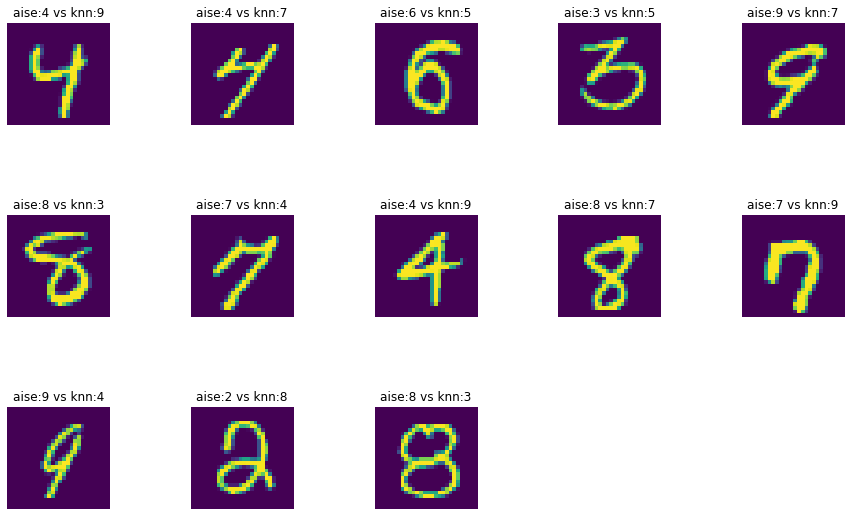

In [12]:
aise_beat_knn = np.nonzero(np.logical_and(aise_pred == y_eval.numpy(),knn_pred != y_eval.numpy()))[0]
set_subplots(data=(X_eval.numpy().squeeze(1),aise_pred,knn_pred))(aise_beat_knn)

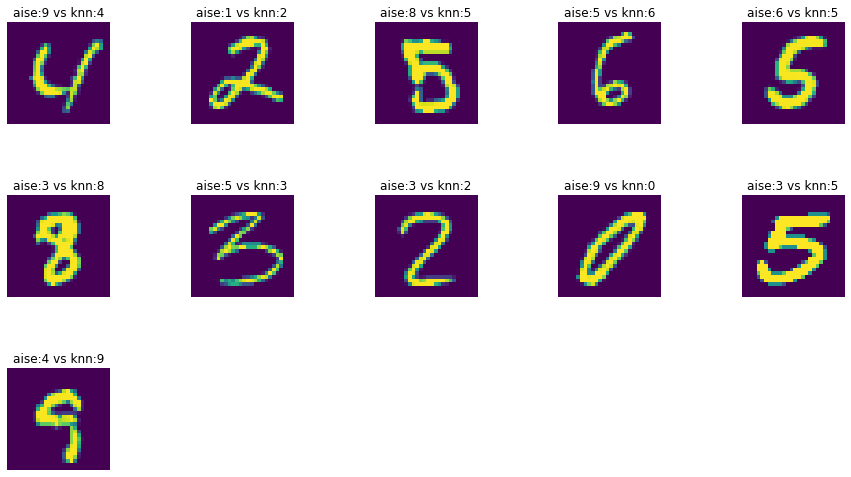

In [13]:
knn_beat_aise = np.nonzero(np.logical_and(aise_pred != y_eval.numpy(),knn_pred == y_eval.numpy()))[0]
set_subplots(data=(X_eval.numpy().squeeze(1),aise_pred,knn_pred))(knn_beat_aise)

### guided mutation

In [14]:
aise = AISE(X_train_partial,y_train_partial,model=model,fitness_function=neg_l2_dist)
start_time = time.time()
mem_bcs,mem_labs,pla_bcs,pla_labs,fit_log = aise.clonal_expansion(X_adv.cpu(),return_log=True)
end_time = time.time()
print("Total running time is {}s.".format(end_time-start_time))
aise_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],pla_labs.numpy())))
print('The accuracy of majority voting by AISE against adversarial samples is: {}'.format((aise_pred==y_eval.numpy()).mean()))

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_partial.flatten(start_dim=1).numpy(),y_train_partial.numpy())
knn_pred = knn.predict(X_adv.cpu().numpy().reshape(X_adv.size(0),-1))
print('The accuaracy of plain KNN against adversarial samples is: {}'.format((knn_pred==y_eval.numpy()).mean()))

Building query objects for 10 classes 2000 samples...done!
Clonal expansion starts...
Searching 10 naive B cells per class for each of 200 antigens...done!
Affinity maturation process starts with population of 1000...
Memory & plasma B cells generated!
10000 plasma B cells and 40000 memory generated!
Total running time is 161.49924230575562s.
The accuracy of majority voting by AISE against adversarial samples is: 0.835
The accuaracy of plain KNN against adversarial samples is: 0.825


Text(0.5, 1.0, 'Histogram of KNN confidence')

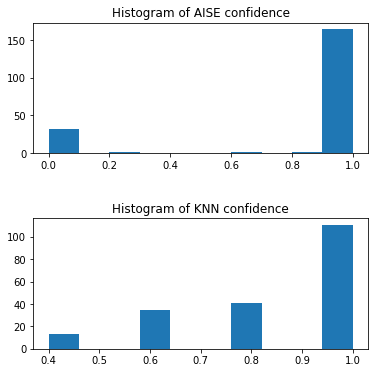

In [15]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=.5)
plt.subplot(2,1,1)
plt.hist((pla_labs==y_eval.reshape(-1,1)).float().mean(dim=1))
plt.title('Histogram of AISE confidence')
plt.subplot(2,1,2)
plt.hist(knn.predict_proba(X_adv.detach().cpu().flatten(start_dim=1).numpy()).max(axis=1))
plt.title('Histogram of KNN confidence')

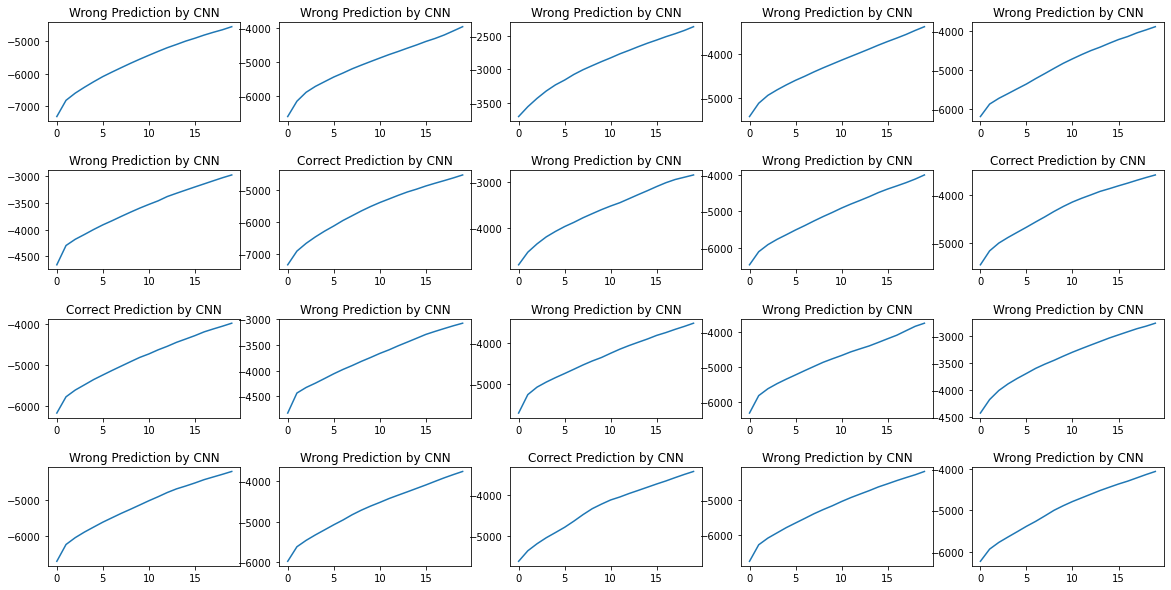

In [16]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=.5)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.plot(fit_log[i])
    plt.title(f'{"Wrong" if y_pred_adv[i].item()!=y_eval[i].item() else "Correct"} Prediction by CNN')

### guided mutation combined with random(uniform) mutation

In [17]:
aise = AISE(X_train_partial,y_train_partial,model=model,fitness_function=neg_l2_dist,mut_mode="combined",combine_prob=.3)
start_time = time.time()
mem_bcs,mem_labs,pla_bcs,pla_labs,fit_log = aise.clonal_expansion(X_adv.cpu(),return_log=True)
end_time = time.time()
print("Total running time is {}s.".format(end_time-start_time))
aise_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],pla_labs.numpy())))
print('The accuracy of majority voting by AISE against adversarial samples is: {}'.format((aise_pred==y_eval.numpy()).mean()))

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_partial.flatten(start_dim=1).numpy(),y_train_partial.numpy())
knn_pred = knn.predict(X_adv.cpu().numpy().reshape(X_adv.size(0),-1))
print('The accuaracy of plain KNN against adversarial samples is: {}'.format((knn_pred==y_eval.numpy()).mean()))

Building query objects for 10 classes 2000 samples...done!
Clonal expansion starts...
Searching 10 naive B cells per class for each of 200 antigens...done!
Affinity maturation process starts with population of 1000...
Memory & plasma B cells generated!
10000 plasma B cells and 40000 memory generated!
Total running time is 169.63008975982666s.
The accuracy of majority voting by AISE against adversarial samples is: 0.83
The accuaracy of plain KNN against adversarial samples is: 0.825


Text(0.5, 1.0, 'Histogram of KNN confidence')

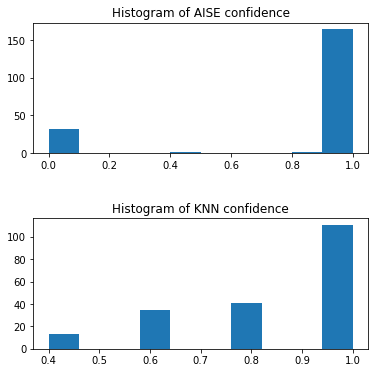

In [18]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=.5)
plt.subplot(2,1,1)
plt.hist((pla_labs==y_eval.reshape(-1,1)).float().mean(dim=1))
plt.title('Histogram of AISE confidence')
plt.subplot(2,1,2)
plt.hist(knn.predict_proba(X_adv.detach().cpu().flatten(start_dim=1).numpy()).max(axis=1))
plt.title('Histogram of KNN confidence')

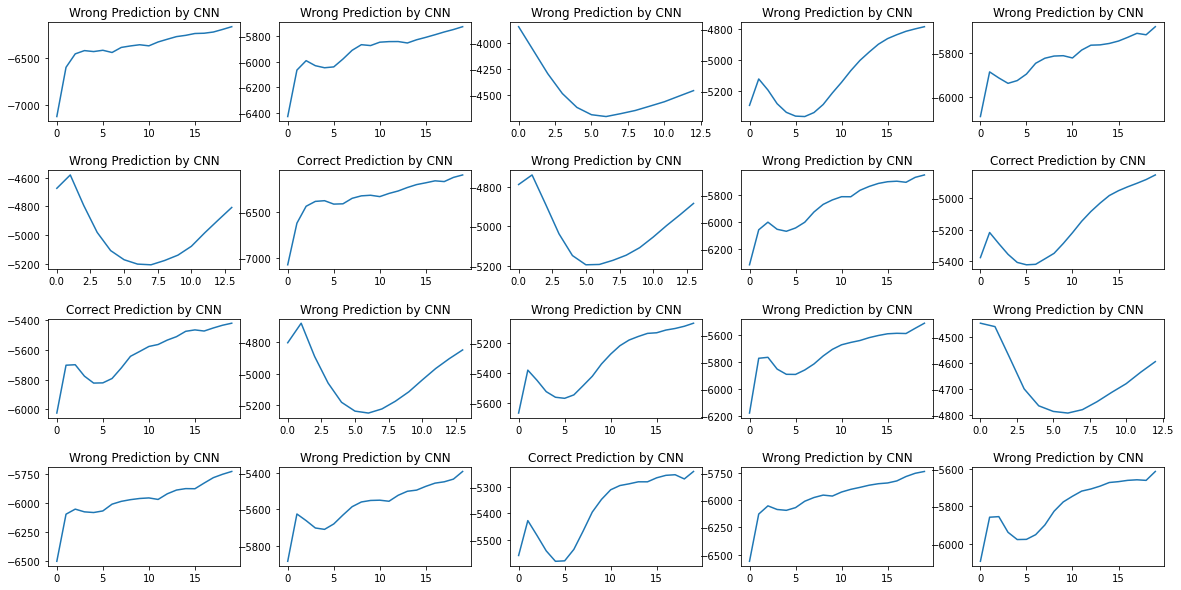

In [19]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=.5)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.plot(fit_log[i])
    plt.title(f'{"Wrong" if y_pred_adv[i].item()!=y_eval[i].item() else "Correct"} Prediction by CNN')

#### combine prob = .5

In [20]:
aise = AISE(X_train_partial,y_train_partial,model=model,fitness_function=neg_l2_dist,mut_mode="combined",combine_prob=.5)
start_time = time.time()
mem_bcs,mem_labs,pla_bcs,pla_labs,fit_log = aise.clonal_expansion(X_adv.cpu(),return_log=True)
end_time = time.time()
print("Total running time is {}s.".format(end_time-start_time))
aise_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],pla_labs.numpy())))
print('The accuracy of majority voting by AISE against adversarial samples is: {}'.format((aise_pred==y_eval.numpy()).mean()))

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_partial.flatten(start_dim=1).numpy(),y_train_partial.numpy())
knn_pred = knn.predict(X_adv.cpu().numpy().reshape(X_adv.size(0),-1))
print('The accuaracy of plain KNN against adversarial samples is: {}'.format((knn_pred==y_eval.numpy()).mean()))

Building query objects for 10 classes 2000 samples...done!
Clonal expansion starts...
Searching 10 naive B cells per class for each of 200 antigens...done!
Affinity maturation process starts with population of 1000...
Memory & plasma B cells generated!
10000 plasma B cells and 40000 memory generated!
Total running time is 177.05385398864746s.
The accuracy of majority voting by AISE against adversarial samples is: 0.84
The accuaracy of plain KNN against adversarial samples is: 0.825


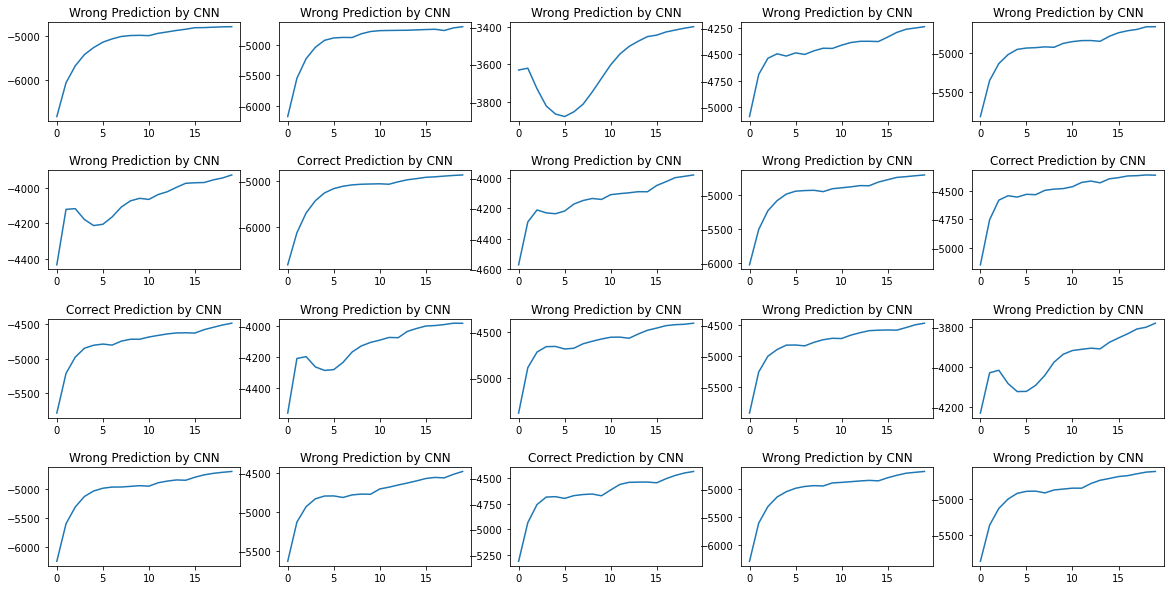

In [21]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=.5)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.plot(fit_log[i])
    plt.title(f'{"Wrong" if y_pred_adv[i].item()!=y_eval[i].item() else "Correct"} Prediction by CNN')

Text(0.5, 1.0, 'Histogram of KNN confidence')

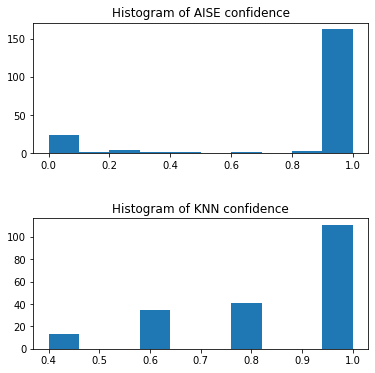

In [22]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=.5)
plt.subplot(2,1,1)
plt.hist((pla_labs==y_eval.reshape(-1,1)).float().mean(dim=1))
plt.title('Histogram of AISE confidence')
plt.subplot(2,1,2)
plt.hist(knn.predict_proba(X_adv.detach().cpu().flatten(start_dim=1).numpy()).max(axis=1))
plt.title('Histogram of KNN confidence')

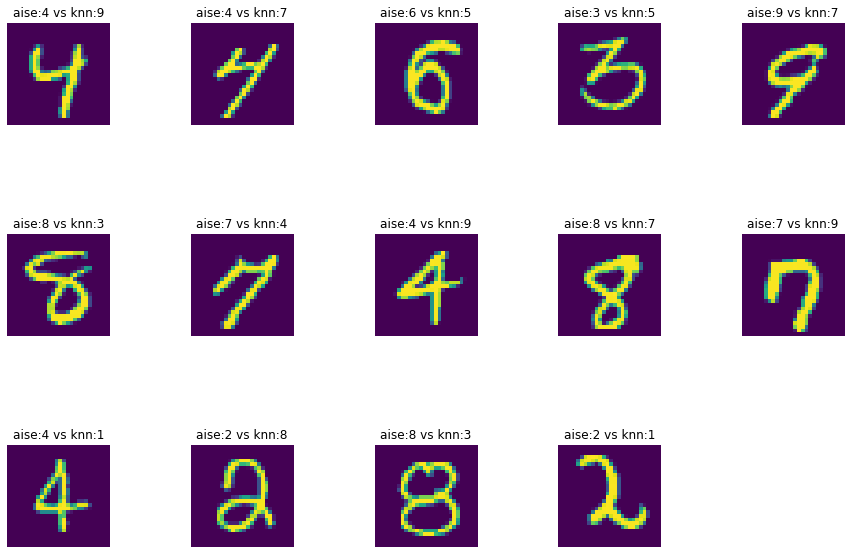

In [23]:
aise_beat_knn = np.nonzero(np.logical_and(aise_pred == y_eval.numpy(),knn_pred != y_eval.numpy()))[0]
set_subplots(data=(X_eval.numpy().squeeze(1),aise_pred,knn_pred))(aise_beat_knn)

#### combine prob = .7

In [57]:
aise = AISE(X_train_partial,y_train_partial,n_class=0,n_neighbors=100,model=model,fitness_function=neg_l2_dist,mut_mode="combined",combine_prob=.7)
start_time = time.time()
mem_bcs,mem_labs,pla_bcs,pla_labs,fit_log = aise.clonal_expansion(X_adv.cpu(),return_log=True)
end_time = time.time()
print("Total running time is {}s.".format(end_time-start_time))
aise_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],pla_labs.numpy())))
print('The accuracy of majority voting by AISE against adversarial samples is: {}'.format((aise_pred==y_eval.numpy()).mean()))

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_partial.flatten(start_dim=1).numpy(),y_train_partial.numpy())
knn_pred = knn.predict(X_adv.cpu().numpy().reshape(X_adv.size(0),-1))
print('The accuaracy of plain KNN against adversarial samples is: {}'.format((knn_pred==y_eval.numpy()).mean()))

Building one single query object 5000 samples...done!
Clonal expansion starts...
Searching 100 naive B cells for each of 500 antigens...done!
Affinity maturation process starts with population of 1000...
Memory & plasma B cells generated!
25000 plasma B cells and 100000 memory generated!
Total running time is 452.5509731769562s.
The accuracy of majority voting by AISE against adversarial samples is: 0.852
The accuaracy of plain KNN against adversarial samples is: 0.852


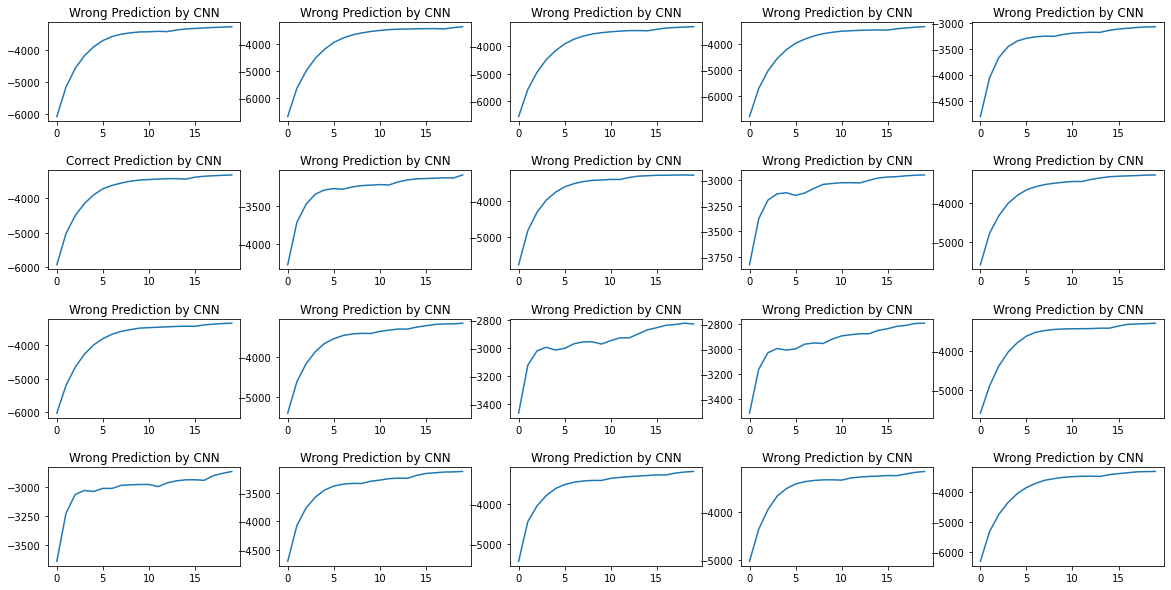

In [58]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=.5)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.plot(fit_log[i])
    plt.title(f'{"Wrong" if y_pred_adv[i].item()!=y_eval[i].item() else "Correct"} Prediction by CNN')
plt.savefig('Population fitness score.jpg')

Text(0.5, 1.0, 'Histogram of KNN confidence')

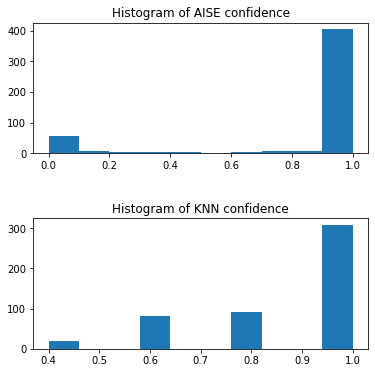

In [59]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=.5)
plt.subplot(2,1,1)
plt.hist((pla_labs==y_eval.reshape(-1,1)).float().mean(dim=1))
plt.title('Histogram of AISE confidence')
plt.subplot(2,1,2)
plt.hist(knn.predict_proba(X_adv.detach().cpu().flatten(start_dim=1).numpy()).max(axis=1))
plt.title('Histogram of KNN confidence')

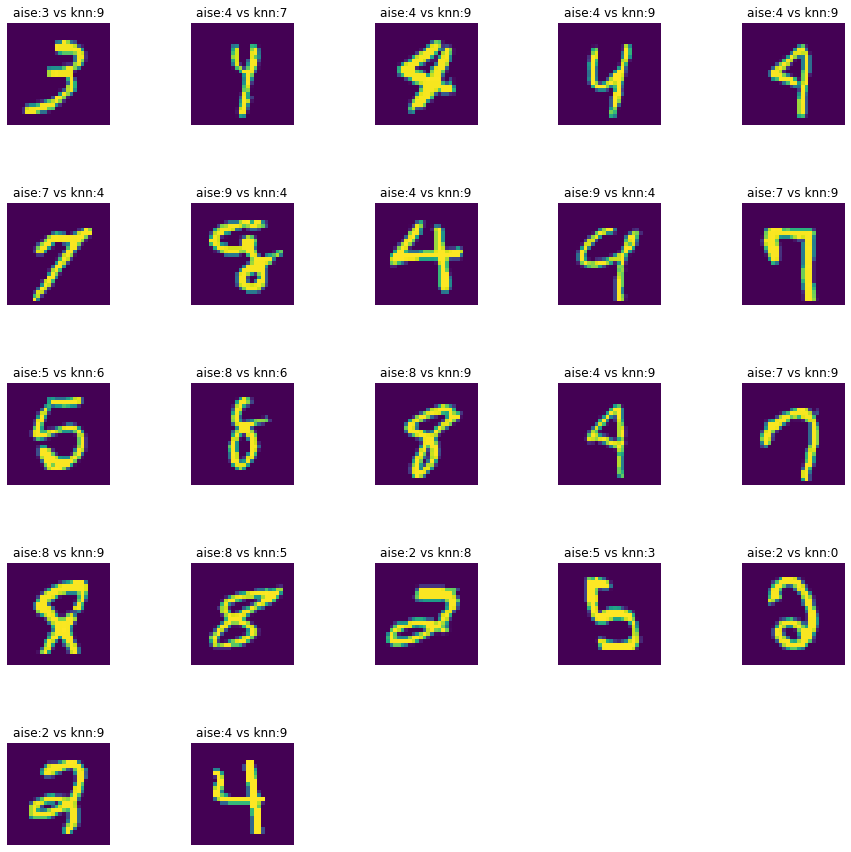

In [60]:
aise_beat_knn = np.nonzero(np.logical_and(aise_pred == y_eval.numpy(),knn_pred != y_eval.numpy()))[0]
set_subplots(data=(X_eval.numpy().squeeze(1),aise_pred,knn_pred))(aise_beat_knn)

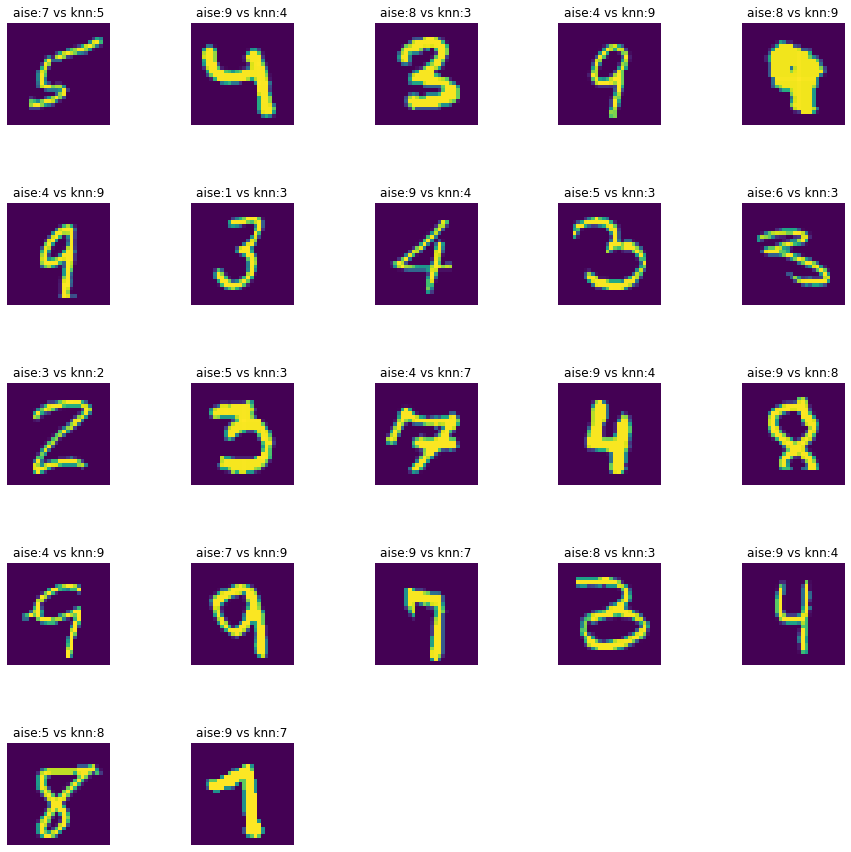

In [61]:
knn_beat_aise = np.nonzero(np.logical_and(aise_pred != y_eval.numpy(),knn_pred == y_eval.numpy()))[0]
set_subplots(data=(X_eval.numpy().squeeze(1),aise_pred,knn_pred))(knn_beat_aise)

In [9]:
aise = AISE(X_train_partial,y_train_partial,n_class=0,n_neighbors=100,model=model,fitness_function=neg_l2_dist,mut_mode="hybrid",combine_rate=.7,hybrid_rate=.9)
start_time = time.time()
mem_bcs,mem_labs,pla_bcs,pla_labs,fit_log = aise.clonal_expansion(X_adv.cpu(),return_log=True)
end_time = time.time()
print("Total running time is {}s.".format(end_time-start_time))
aise_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],pla_labs.numpy())))
print('The accuracy of majority voting by AISE against adversarial samples is: {}'.format((aise_pred==y_eval.numpy()).mean()))

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_partial.flatten(start_dim=1).numpy(),y_train_partial.numpy())
knn_pred = knn.predict(X_adv.cpu().numpy().reshape(X_adv.size(0),-1))
print('The accuaracy of plain KNN against adversarial samples is: {}'.format((knn_pred==y_eval.numpy()).mean()))

Building one single query object 2000 samples...done!
Clonal expansion starts...
Searching 100 naive B cells for each of 200 antigens...done!
Affinity maturation process starts with population of 1000...
Memory & plasma B cells generated!
10000 plasma B cells and 40000 memory generated!
Total running time is 178.13046956062317s.
The accuracy of majority voting by AISE against adversarial samples is: 0.82
The accuaracy of plain KNN against adversarial samples is: 0.835


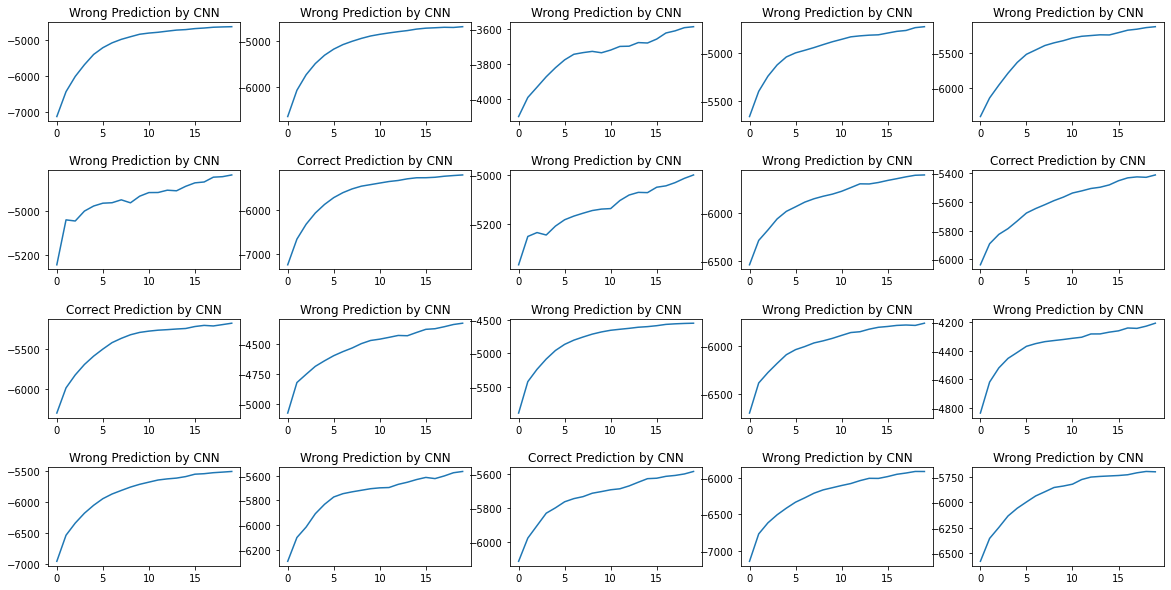

In [10]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=.5)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.plot(fit_log[i])
    plt.title(f'{"Wrong" if y_pred_adv[i].item()!=y_eval[i].item() else "Correct"} Prediction by CNN')
plt.savefig('Population fitness score.jpg')

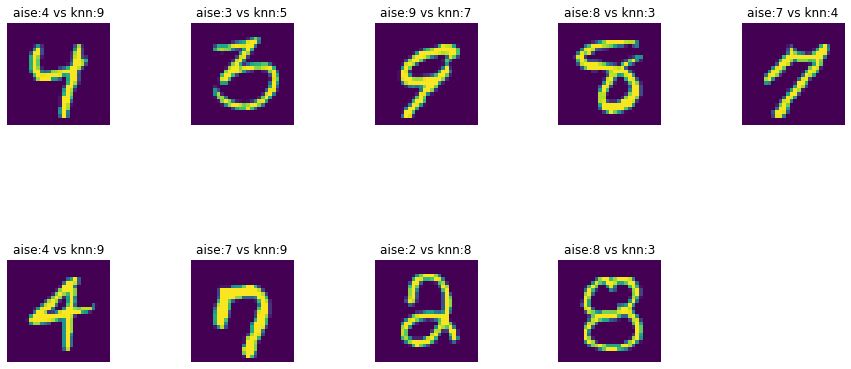

In [13]:
aise_beat_knn = np.nonzero(np.logical_and(aise_pred == y_eval.numpy(),knn_pred != y_eval.numpy()))[0]
set_subplots(data=(X_eval.numpy().squeeze(1),aise_pred,knn_pred))(aise_beat_knn)

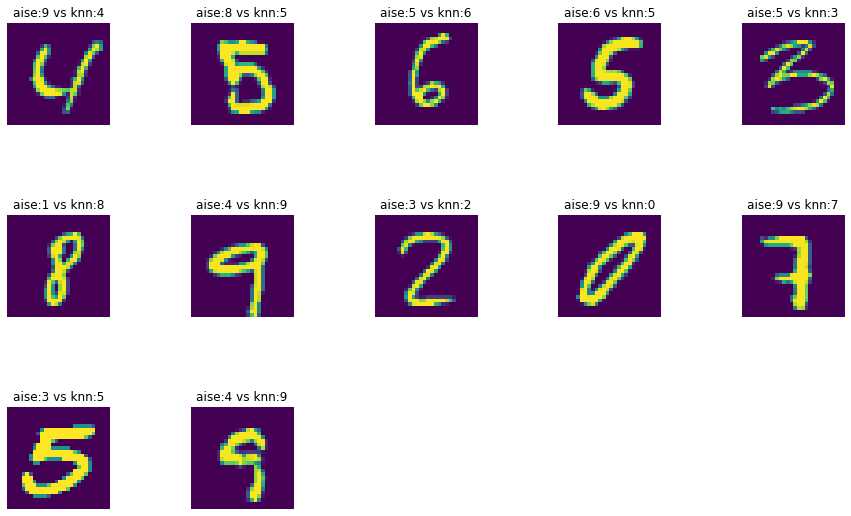

In [14]:
knn_beat_aise = np.nonzero(np.logical_and(aise_pred != y_eval.numpy(),knn_pred == y_eval.numpy()))[0]
set_subplots(data=(X_eval.numpy().squeeze(1),aise_pred,knn_pred))(knn_beat_aise)

In [15]:
aise = AISE(X_train_partial,y_train_partial,n_class=0,max_generation=50,n_neighbors=100,model=model,fitness_function=neg_l2_dist,mut_mode="hybrid",combine_rate=.7,hybrid_rate=.9)
start_time = time.time()
mem_bcs,mem_labs,pla_bcs,pla_labs,fit_log = aise.clonal_expansion(X_adv.cpu(),return_log=True)
end_time = time.time()
print("Total running time is {}s.".format(end_time-start_time))
aise_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],pla_labs.numpy())))
print('The accuracy of majority voting by AISE against adversarial samples is: {}'.format((aise_pred==y_eval.numpy()).mean()))

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_partial.flatten(start_dim=1).numpy(),y_train_partial.numpy())
knn_pred = knn.predict(X_adv.cpu().numpy().reshape(X_adv.size(0),-1))
print('The accuaracy of plain KNN against adversarial samples is: {}'.format((knn_pred==y_eval.numpy()).mean()))

Building one single query object 2000 samples...done!
Clonal expansion starts...
Searching 100 naive B cells for each of 200 antigens...done!
Affinity maturation process starts with population of 1000...
Memory & plasma B cells generated!
10000 plasma B cells and 40000 memory generated!
Total running time is 435.3265209197998s.
The accuracy of majority voting by AISE against adversarial samples is: 0.835
The accuaracy of plain KNN against adversarial samples is: 0.835


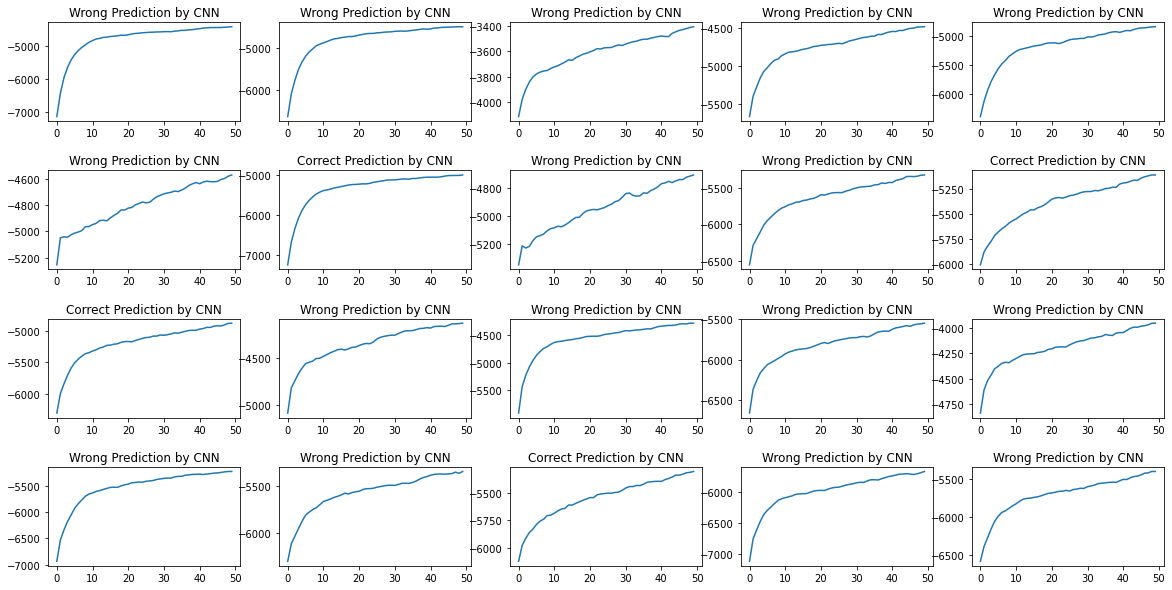

In [16]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=.5)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.plot(fit_log[i])
    plt.title(f'{"Wrong" if y_pred_adv[i].item()!=y_eval[i].item() else "Correct"} Prediction by CNN')
plt.savefig('Population fitness score.jpg')

In [28]:
# grid search
param_dict = {
# 'mut_range':[.15,.3,.4],
'mut_range':[.15],
'mut_prob':[.05,.1,.2],
'combine_prob':[.3,.5,.7],
'layer_dims':[[],[0,],[1,]],
'max_generation':[10,20,30]
}

import itertools

def dict2str(d):
  s = []
  for k,v in d.items():
    s.append(f'{k}={v}')
  return ','.join(s)

def gridsearch(func,param_dict):
  val_product = list(itertools.product(*param_dict.values()))
  print('{} sets of hyperparameters found!'.format(len(list(val_product))))
  print('Grid search starts...')
  result_dict = {}
  for vs in val_product:
    temp_dict = dict(zip(param_dict.keys(),vs))
    print('# {}'.format(dict2str(temp_dict)))
    temp_metric = func(**temp_dict)
    # print('acc: {}'.format(temp_metric))
    result_dict[dict2str(temp_dict)] = temp_metric
  return result_dict

def test_aise(mut_range,mut_prob,combine_prob,layer_dims,X_orig=X_train_partial,y_orig=y_train_partial,X_hidden=X_hidden_partial,ant=X_adv,y_true=y_eval,
              model=model,device=DEVICE):
  aise = AISE(X_orig,y_orig,X_hidden,combine_prob=combine_prob,mut_range=mut_range,mut_prob=mut_prob,layer_dims=layer_dims,model=model,fitness_function=neg_l2_dist,device=device)
  start_time = time.time()
  mem_bcs,mem_labs,pla_bcs,pla_labs,fit_log = aise.clonal_expansion(X_adv.cpu(),return_log=True)
  end_time = time.time()
  print("Total running time is {}s.".format(end_time-start_time))
  y_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],pla_labs.numpy())))
  acc = (y_pred==y_eval.numpy()).mean()
  print('The accuracy of majority voting by AISE against adversarial samples is: {}'.format(acc))
  return acc

NameError: name 'DEVICE' is not defined